# Notes on learning DESI tutorials
- https://github.com/desihub/tutorials

#### Check DESI kernel

Populating the interactive namespace from numpy and matplotlib
desimodel  0.9.10
desispec   0.28.0
desitarget 0.28.0


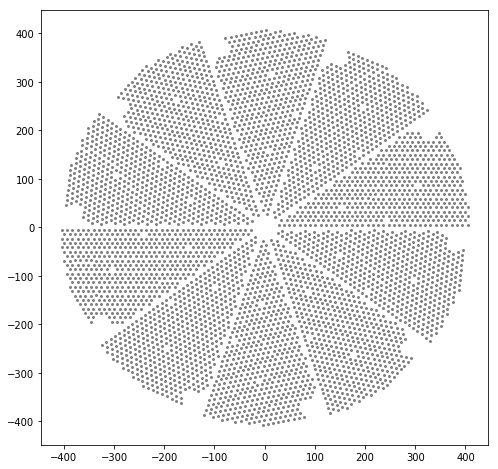

In [2]:
%pylab inline
import desispec
import desitarget
import desimodel.io
print('desimodel ', desimodel.__version__)
print('desispec  ', desispec.__version__)
print('desitarget', desitarget.__version__)

fiberpos = desimodel.io.load_fiberpos()
figure(figsize=(8,8))
plot(fiberpos['X'], fiberpos['Y'], 'k.', alpha=0.5, markeredgecolor='none')

#### Import required modules

In [1]:
import os
import numpy as np
import healpy as hp
from glob import glob
import fitsio
from collections import defaultdict
import matplotlib.pyplot as plt
%pylab inline

# DESI modules
from desitarget.targetmask import desi_mask
import desispec.io

Populating the interactive namespace from numpy and matplotlib


In [4]:
# version of the modules
print('healpy: ', hp.__version__)
print('numpy: ', np.__version__)
print('fitsio: ', fitsio.__version__)

healpy:  1.11.0
numpy:  1.13.3
fitsio:  0.9.11


---

#### Environment variables and data

- Data are under `$DESI_SPECTRO_REDUX/$SPECPROD`.
  - Spectro production runs are grouped under `$DESI_SPECTRO_REDUX`.
  - `$SPECPROD` indicates which run to use.

In [5]:
%set_env DESI_SPECTRO_REDUX=/project/projectdirs/desi/datachallenge/reference_runs/19.2/spectro/redux/
%set_env SPECPROD=mini

env: DESI_SPECTRO_REDUX=/project/projectdirs/desi/datachallenge/reference_runs/19.2/spectro/redux/
env: SPECPROD=mini


In [6]:
reduxdir = desispec.io.specprod_root()
print(reduxdir)

/project/projectdirs/desi/datachallenge/reference_runs/19.2/spectro/redux/mini


In [7]:
#- Do check that these are set correctly before proceeding
def check_env():
    for env in ('DESI_SPECTRO_REDUX', 'SPECPROD'):
        if env in os.environ:
            print('${}={}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

    reduxdir = desispec.io.specprod_root()
    if not os.path.exists(reduxdir):
        print("ERROR: {} doesn't exist; check $DESI_SPECTRO_REDUX/$SPECPROD".format(reduxdir))
    else:
        print('OK: {} exists'.format(reduxdir))

check_env()

$DESI_SPECTRO_REDUX=/project/projectdirs/desi/datachallenge/reference_runs/19.2/spectro/redux/
$SPECPROD=mini
OK: /project/projectdirs/desi/datachallenge/reference_runs/19.2/spectro/redux/mini exists


---

### Data model for the spectra

- All the calibrated spectra are grouped with Healpix.
- The directory structure is `$DESI_SPECTRO_REDUX/$SPECPROD/spectra-{nside}/{group}/{pix}/*-{nside}-{pix}.fits`.
  - `group = pix // 100`
  - `*` can be `spectra` or `zbest` with best-fit redshifts from redrock.

In [18]:
basedir = os.path.join(os.getenv('DESI_SPECTRO_REDUX'), os.getenv('SPECPROD'), 'spectra-64')
subdir = os.listdir(basedir)
print(basedir)
print(subdir)

basedir = os.path.join(basedir, subdir[0])
subdir = os.listdir(basedir)
print(basedir)
print(subdir)

basedir = os.path.join(basedir, subdir[0])
subdir = os.listdir(basedir)
print(basedir)
print(subdir)

/project/projectdirs/desi/datachallenge/reference_runs/19.2/spectro/redux/mini/spectra-64
['53', '56', '52']
/project/projectdirs/desi/datachallenge/reference_runs/19.2/spectro/redux/mini/spectra-64/53
['5302', '5310', '5311', '5346', '5307', '5308', '5309', '5303', '5304', '5305', '5352', '5306', '5354', '5300', '5301']
/project/projectdirs/desi/datachallenge/reference_runs/19.2/spectro/redux/mini/spectra-64/53/5302
['spectra-64-5302.fits', 'redrock-64-5302.h5', 'zbest-64-5302.fits']


In [19]:
# desispec.io
desispec.io.findfile('spectra', groupname=5302)

'/project/projectdirs/desi/datachallenge/reference_runs/19.2/spectro/redux/mini/spectra-64/53/5302/spectra-64-5302.fits'

#### Spectra file format

In [62]:
specfiles = sorted(glob(reduxdir + '/spectra-64/*/*/spectra*.fits'))
specfilename = specfiles[2]
DM = fitsio.FITS(specfilename)
DM


  file: /project/projectdirs/desi/datachallenge/reference_runs/19.2/spectro/redux/mini/spectra-64/52/5263/spectra-64-5263.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      BINARY_TBL      SCORES
  3      IMAGE_HDU       B_WAVELENGTH
  4      IMAGE_HDU       B_FLUX
  5      IMAGE_HDU       B_IVAR
  6      IMAGE_HDU       B_MASK
  7      IMAGE_HDU       B_RESOLUTION
  8      IMAGE_HDU       R_WAVELENGTH
  9      IMAGE_HDU       R_FLUX
  10     IMAGE_HDU       R_IVAR
  11     IMAGE_HDU       R_MASK
  12     IMAGE_HDU       R_RESOLUTION
  13     IMAGE_HDU       Z_WAVELENGTH
  14     IMAGE_HDU       Z_FLUX
  15     IMAGE_HDU       Z_IVAR
  16     IMAGE_HDU       Z_MASK
  17     IMAGE_HDU       Z_RESOLUTION

##### FIBERMAP

- `FIBERMAP` stores the mapping of the imaging information used to target and place a fiber on the source.

In [63]:
fm = fitsio.read(specfilename, 'FIBERMAP')
fm.dtype.descr

[('TARGETID', '>i8'),
 ('DESI_TARGET', '>i8'),
 ('BGS_TARGET', '>i8'),
 ('MWS_TARGET', '>i8'),
 ('SECONDARY_TARGET', '>i8'),
 ('TARGET_RA', '>f8'),
 ('TARGET_DEC', '>f8'),
 ('TARGET_RA_IVAR', '>f8'),
 ('TARGET_DEC_IVAR', '>f8'),
 ('BRICKID', '>i8'),
 ('BRICK_OBJID', '>i8'),
 ('MORPHTYPE', '|S4'),
 ('PRIORITY', '>i4'),
 ('SUBPRIORITY', '>f8'),
 ('REF_ID', '>i8'),
 ('PMRA', '>f4'),
 ('PMDEC', '>f4'),
 ('PMRA_IVAR', '>f4'),
 ('PMDEC_IVAR', '>f4'),
 ('FLUX_G', '>f4'),
 ('FLUX_R', '>f4'),
 ('FLUX_Z', '>f4'),
 ('FLUX_W1', '>f4'),
 ('FLUX_W2', '>f4'),
 ('FLUX_IVAR_G', '>f4'),
 ('FLUX_IVAR_R', '>f4'),
 ('FLUX_IVAR_Z', '>f4'),
 ('FLUX_IVAR_W1', '>f4'),
 ('FLUX_IVAR_W2', '>f4'),
 ('FIBERFLUX_G', '>f4'),
 ('FIBERFLUX_R', '>f4'),
 ('FIBERFLUX_Z', '>f4'),
 ('FIBERFLUX_W1', '>f4'),
 ('FIBERFLUX_W2', '>f4'),
 ('FIBERTOTFLUX_G', '>f4'),
 ('FIBERTOTFLUX_R', '>f4'),
 ('FIBERTOTFLUX_Z', '>f4'),
 ('FIBERTOTFLUX_W1', '>f4'),
 ('FIBERTOTFLUX_W2', '>f4'),
 ('MW_TRANSMISSION_G', '>f4'),
 ('MW_TRANSMISSION_R',

##### WAVELENGTH

- Note that the wavelength arrays are 1-D (every spectrum in the spectral file is mapped to the same binning in wavelength).

In [78]:
bwave = fitsio.read(specfilename, 'B_WAVELENGTH')
rwave = fitsio.read(specfilename, 'R_WAVELENGTH')
zwave = fitsio.read(specfilename, 'Z_WAVELENGTH')
print("B coverage: {:.1f} to {:.1f} Angstroms".format(np.min(bwave),np.max(bwave)))
print("R coverage: {:.1f} to {:.1f} Angstroms".format(np.min(rwave),np.max(rwave)))
print("Z coverage: {:.1f} to {:.1f} Angstroms".format(np.min(zwave),np.max(zwave)))

B coverage: 3569.3 to 5948.5 Angstroms
R coverage: 5625.3 to 7740.5 Angstroms
Z coverage: 7435.3 to 9833.7 Angstroms


In [80]:
print(bwave.shape)

(2975,)


##### FLUX

- The flux array (and flux_ivar, mask etc. arrays) are 2-D, because they contain multiple spectra.

In [79]:
bflux = fitsio.read(specfilename,'B_FLUX')
rflux = fitsio.read(specfilename,'R_FLUX')
zflux = fitsio.read(specfilename,'Z_FLUX')

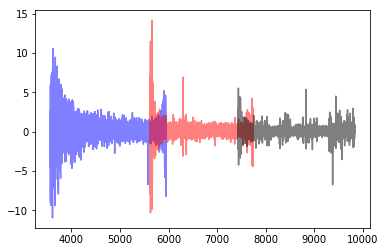

In [88]:
spectrum = 0
plt.plot(bwave,bflux[spectrum], 'b', alpha=0.5)
plt.plot(rwave,rflux[spectrum], 'r', alpha=0.5)
plt.plot(zwave,zflux[spectrum], 'k', alpha=0.5)

### DESI-specific spectrum reader

In [89]:
specobj = desispec.io.read_spectra(specfilename)

In [90]:
specobj.wave

{'b': array([ 3569.3,  3570.1,  3570.9, ...,  5946.9,  5947.7,  5948.5]),
 'r': array([ 5625.3,  5626.1,  5626.9, ...,  7738.9,  7739.7,  7740.5]),
 'z': array([ 7435.3,  7436.1,  7436.9, ...,  9832.1,  9832.9,  9833.7])}

In [95]:
specobj.flux

{'b': array([[ -4.44917297,   5.91132069,   3.36374617, ...,  -5.43211126,
           1.23149192,   0.5232538 ],
        [  5.01340199,  -4.07736778,  -2.85891485, ...,   0.34274864,
           2.24843884,   7.60697699],
        [  1.05670679,  -2.97938633,   5.98110294, ...,  -1.55714762,
          -1.35028291,   1.88797033],
        ..., 
        [ -7.10617781,   1.75557959,   2.01467061, ..., -16.51118469,
          -1.03650367,  -1.56022418],
        [ -3.15484405,  -4.63223076,   5.63041687, ...,   0.40663308,
         -11.52686977,   3.07458305],
        [  3.69688749,  -6.44705868,  39.10839081, ...,  -6.44642401,
          12.61435795,  15.90933514]]),
 'r': array([[  6.25745821e+00,  -7.92421532e+00,   1.04103765e+01, ...,
          -4.42914629e+00,   8.24960530e-01,   1.81631994e+00],
        [  3.64575100e+00,   4.65795374e+00,  -6.48851633e+00, ...,
           1.48326015e+00,  -1.36185169e+00,  -4.79864478e-01],
        [ -5.19985676e-01,  -7.02103949e+00,   1.34250507e+01,

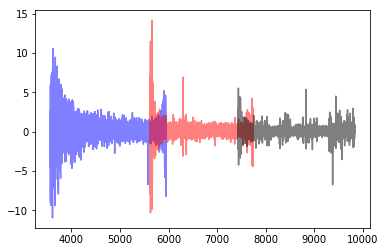

In [96]:
spectrum = 0
plt.plot(specobj.wave["b"], specobj.flux["b"][spectrum], color='b', alpha=0.5)
plt.plot(specobj.wave["r"], specobj.flux["r"][spectrum], color='r', alpha=0.5)
plt.plot(specobj.wave["z"], specobj.flux["z"][spectrum], color='k', alpha=0.5)

In [102]:
specobj.fibermap

TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SECONDARY_TARGET,TARGET_RA,TARGET_DEC,TARGET_RA_IVAR,TARGET_DEC_IVAR,BRICKID,BRICK_OBJID,MORPHTYPE,PRIORITY,SUBPRIORITY,REF_ID,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERFLUX_W1,FIBERFLUX_W2,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,FIBERTOTFLUX_W1,FIBERTOTFLUX_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,EBV,PHOTSYS,FIBER,PETAL_LOC,DEVICE_LOC,LOCATION,FIBERSTATUS,OBJTYPE,LAMBDA_REF,DESIGN_X,DESIGN_Y,DESIGN_Q,DESIGN_S,NUMTARGET,FIBER_RA,FIBER_DEC,FIBER_RA_IVAR,FIBER_DEC_IVAR,DELTA_X,DELTA_Y,DELTA_X_IVAR,DELTA_Y_IVAR,NUM_ITER,SPECTROID,BRICKNAME,LAMBDAREF,NIGHT,EXPID,TILEID
int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,bytes4,int32,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int32,int32,int32,int32,int32,bytes3,float32,float32,float32,float32,float32,int16,float64,float64,float32,float32,float32,float32,float32,float32,int32,int32,bytes8,float64,int32,int32,int32
288230398226336483,2,0,0,0,151.926116943,29.8613204956,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.499628,0.59038,0.996447,1.22848,0.98329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,4251,8,330,8330,0,TGT,5400.0,-258.576,-162.83,0.0,0.0,0,151.926116943,29.8613204956,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p297,5400.0,20200315,10,28408
288230398226336494,2,0,0,0,151.987716675,29.8390388489,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.419791,0.539089,1.00151,2.26773,1.61942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,4253,8,350,8350,0,TGT,5400.0,-272.608,-168.646,0.0,0.0,0,151.987716675,29.8390388489,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p297,5400.0,20200315,10,28408
288230398226336595,2,0,0,0,151.929733276,29.9063510895,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.388411,0.558551,1.21663,5.65038,6.18624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,4254,8,309,8309,0,TGT,5400.0,-259.016,-151.466,0.0,0.0,0,151.929733276,29.9063510895,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p300,5400.0,20200315,10,28408
288230398226336569,2,0,0,0,151.990264893,29.7623710632,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.454828,0.66976,1.06594,1.95634,1.18871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,4256,8,393,8393,0,TGT,5400.0,-273.906,-188.164,0.0,0.0,0,151.990264893,29.7623710632,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p297,5400.0,20200315,10,28408
288230398226336626,2,0,0,0,152.071411133,29.7806777954,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.670719,0.923241,2.22004,3.78302,2.66169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,4259,8,414,8414,0,TGT,5400.0,-292.126,-183.78,0.0,0.0,0,152.071411133,29.7806777954,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p297,5400.0,20200315,10,28408
288230398226336844,2,0,0,0,151.900558472,29.9603862762,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.773044,1.0015,2.1316,3.93794,2.71674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,4260,8,290,8290,0,TGT,5400.0,-252.089,-137.806,0.0,0.0,0,151.900558472,29.9603862762,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p300,5400.0,20200315,10,28408
288230398226336710,2,0,0,0,151.943954468,29.7640304565,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.689709,0.834829,1.56216,2.55891,1.73825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,4263,8,372,8372,0,TGT,5400.0,-263.445,-187.579,0.0,0.0,0,151.943954468,29.7640304565,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p297,5400.0,20200315,10,28408
288230398226336934,2,0,0,0,152.067871094,29.7247180939,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.763788,1.09716,2.03919,3.7463,2.38057,0.0,0.0,0.0,0.

In [103]:
specobj.target_ids()

288230398226336483
288230398226336494
288230398226336595
288230398226336569
288230398226336626
288230398226336844
288230398226336710
288230398226336934
288230398226336903
288230398226336523
288230398226336882


In [104]:
dir(specobj)

['R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bands',
 '_ftype',
 '_single',
 'bands',
 'extra',
 'fibermap',
 'flux',
 'ftype',
 'ivar',
 'mask',
 'meta',
 'num_spectra',
 'num_targets',
 'resolution_data',
 'scores',
 'select',
 'target_ids',
 'update',
 'wave',
 'wavelength_grid']